<a href="https://colab.research.google.com/github/PorkPy/LSTM-Force-Predictor/blob/master/seq2seq_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

## Imports
import torch
import sys
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
import random

## Set styling parameters for figures
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

## Set random seed for numpy and Torch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Check CUDA is available

In [3]:
torch.cuda.is_available()

True

In [4]:
class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            device = torch.device("cpu")
            print("Running on CPU")

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5)


        self.linear1 = nn.Linear(in_features=n_hidden, out_features=512)
        self.linear2 = nn.Linear(in_features=512, out_features=64)
        self.linear3 = nn.Linear(in_features=64, out_features=1)

    
    
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )
        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear1(last_time_step)
        y_pred = self.linear2(y_pred)
        y_pred = self.linear3(y_pred)
        return y_pred

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on the GPU


In [6]:
def train_model(model):
   

    loss_fn = torch.nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
        
    num_epochs =5

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
              
    model = model.to(device)
    
    
    for j in range(len(batches)): 
        print("Batch num: ", j)
        train_data, train_labels, test_data, test_labels = get_batches(j)       


        for t in range(num_epochs):
        
            model.reset_hidden_state()

            y_pred = model(train_data)

            loss = loss_fn(y_pred.float(), train_labels)

        
            
            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(train_data)
                    test_loss = loss_fn(y_test_pred.float(), train_labels)
                test_hist[t] = test_loss.item()

                if t % 10 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
            elif t % 10 == 0:
                  print(f'Epoch {t} train loss: {loss.item()}')


            train_hist[t] = loss.item()

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
    
    return model.eval(), train_hist, test_hist, optimizer, t, loss_fn

In [7]:
url = 'https://raw.githubusercontent.com/PorkPy/LSTM-Force-Predictor/master/80k_data/mean_force_data.csv'
data = pd.read_csv(url)
#data = data[:80000]
main_seq = data


In [8]:
n=1000
batches = [data[i:i + n] for i in range(0, len(data), n)]
print(len(batches))

random.seed(42)
random.shuffle(batches)

display(batches[0])

test_batches = batches[70:]
batches = batches[:70]
print(len(batches))

72


,joint_0,joint_2,joint_4,joint_5,force_mean
49000,1.404746,2.483058,-1.566886,2.720611,0.000000
49001,1.404758,2.483070,-1.566898,2.720623,0.000000
49002,1.404758,2.483070,-1.566874,2.720623,0.000000
49003,1.404758,2.483070,-1.566898,2.720623,0.000000
49004,1.404770,2.483070,-1.566910,2.720599,0.000000
...,...,...,...,...,...
49995,2.226373,2.119497,-1.572913,2.091492,22.375956
49996,2.226386,2.119534,-1.572746,2.091516,23.538229
49997,2.226373,2.119306,-1.572746,2.091480,24.545295
49998,2.226481,2.119282,-1.572734,2.091516,25.334074


70


In [9]:
print(test_batches[1])

        joint_0   joint_2   joint_4   joint_5  force_mean
14000  1.409388  2.483382 -1.567078  2.717629    0.000000
14001  1.409400  2.483370 -1.567066  2.717641    0.000000
14002  1.409400  2.483358 -1.567090  2.717617    0.000000
14003  1.409388  2.483346 -1.567066  2.717641    0.000000
14004  1.409388  2.483335 -1.567078  2.717629    0.000000
...         ...       ...       ...       ...         ...
14995  2.743801  1.237703 -1.557372  0.894740    2.567632
14996  2.744436  1.238148 -1.557384  0.899844    2.529892
14997  2.744388  1.238220 -1.557396  0.904396    2.477695
14998  2.744388  1.238472 -1.557420  0.907271    2.428476
14999  2.744376  1.238628 -1.557420  0.907391    2.388231

[1000 rows x 5 columns]


In [10]:
featuresscaler2 = batches[0].iloc[:,-1]

x_scaler = MinMaxScaler(feature_range=(-1, 1))

featuresscaler2 = np.asarray(featuresscaler2)
featuresscaler2 = featuresscaler2.reshape(-1,1)
x_scaler = x_scaler.fit(featuresscaler2)

features2 =x_scaler.transform(featuresscaler2)
targets2 = features2[:,-1].reshape(-1,1)

preds2 = targets2

predicted_cases2 = x_scaler.inverse_transform(preds2).reshape(-1,1)

print("original",batches[0].iloc[:5,-1])
print("scaled",targets2[:5])
print("Unscaled",predicted_cases2[:5])

original 49000    0.0
49001    0.0
49002    0.0
49003    0.0
49004    0.0
Name: force_mean, dtype: float64
scaled [[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]
Unscaled [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [11]:
def get_test_batch(batch_number):
    
#     featuresscaler = batches[0]
#     jim = featuresscaler.iloc[:,-1]# capture a seq for display on prediction chart.
#     scaler1 = MinMaxScaler(feature_range=(-1, 1))

#     scaler1 = scaler1.fit(featuresscaler)
#     features = scaler1.transform(featuresscaler)
#     targets = features[:,-1].reshape(-1,1)

    features = test_batches[batch_number].reset_index(drop=True)
    jim = features.iloc[:,-1]
    
    targets = features.iloc[:,-1]
    features = features[['joint_0', 'joint_2', 'joint_4', 'joint_5', 'force_mean']]
    features = np.asarray(features)
    
    targets = np.asarray(targets)
    targets - targets.reshape(-1,1)
    
    

    


    def test_create_sequences(seq_length):
        xs = []
        ys = []

        for i in range(len(features)-seq_length):
            x = features[i:(i+seq_length)]
            #print(i,(i+seq_length))
            y = targets[i+seq_length]
            #print(i+seq_length+1)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    seq_length = 250

    Xtest, ytest = test_create_sequences(seq_length)

    Xtest = torch.cuda.FloatTensor(Xtest)
    ytest = torch.cuda.FloatTensor(ytest)

    return(Xtest, ytest, jim)
  

In [12]:
def get_batches(batch_num):  
    
    data = batches[batch_num].reset_index(drop=True)

    ################################################

    features_scaler = data  

#     scaler = MinMaxScaler(feature_range=(-1, 1))

#     scaler = scaler.fit(features_scaler)
#     features = scaler.transform(features_scaler)
#     targets = features[:,-1].reshape(-1,1)
    ###################################################

    
    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5', 'force_mean']]
    features = np.asarray(features)
    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)
    features = np.asarray(features)
    
    
    
    test_data_size = 500

    X_train = features[:-test_data_size]
    X_test = features[-test_data_size:]
    y_train = targets[:-test_data_size]
    y_test = targets[-test_data_size:]

    ####################################################

    def train_create_sequences(seq_length):
        xs = []
        ys = []

        for i in range(len(X_train)-seq_length):
            x = X_train[i:(i+seq_length)]
            #print(i,(i+seq_length))
            y = y_train[i+seq_length]
            #print(i+seq_length+1)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    def test_create_sequences(seq_length):
        xs = []
        ys = []

        for i in range(len(X_test)-seq_length):
            x = X_test[i:(i+seq_length)]
            #print(i,(i+seq_length))
            y = y_test[i+seq_length]
            #print(i+seq_length+1)
            xs.append(x)
            ys.append(y)

        return np.array(xs), np.array(ys)

    #######################################################


    X_train, y_train = train_create_sequences(seq_length)
    X_test, y_test = test_create_sequences(seq_length)

    X_train = torch.cuda.FloatTensor(X_train)
    y_train = torch.cuda.FloatTensor(y_train)
    X_test = torch.cuda.FloatTensor(X_test)
    y_test = torch.cuda.FloatTensor(y_test)
    
    return(X_train, y_train, X_test, y_test)

In [13]:
seq_length = 250

model = CoronaVirusPredictor(
      n_features=5, 
      n_hidden=256, 
      seq_len=seq_length, 
      n_layers=2 
    )

model, train_hist, test_hist, optimizer, epochs, loss = train_model(model)

Running on the GPU
Batch num:  0
Epoch 0 train loss: 193.04489135742188 test loss: 193.03834533691406
Batch num:  1
Epoch 0 train loss: 17.398237228393555 test loss: 17.39649772644043
Batch num:  2
Epoch 0 train loss: 12.91747760772705 test loss: 12.920723915100098
Batch num:  3
Epoch 0 train loss: 154.90167236328125 test loss: 154.91455078125
Batch num:  4
Epoch 0 train loss: 90.13026428222656 test loss: 90.1172103881836
Batch num:  5
Epoch 0 train loss: 11.698720932006836 test loss: 11.704740524291992
Batch num:  6
Epoch 0 train loss: 887.1470336914062 test loss: 886.8204345703125
Batch num:  7
Epoch 0 train loss: 1.9540767669677734 test loss: 1.9729552268981934
Batch num:  8
Epoch 0 train loss: 0.9177753925323486 test loss: 0.9509353637695312
Batch num:  9
Epoch 0 train loss: 42.45869064331055 test loss: 42.5375862121582
Batch num:  10
Epoch 0 train loss: 6.037959098815918 test loss: 6.123555660247803
Batch num:  11
Epoch 0 train loss: 3.8095052242279053 test loss: 3.821690320968628

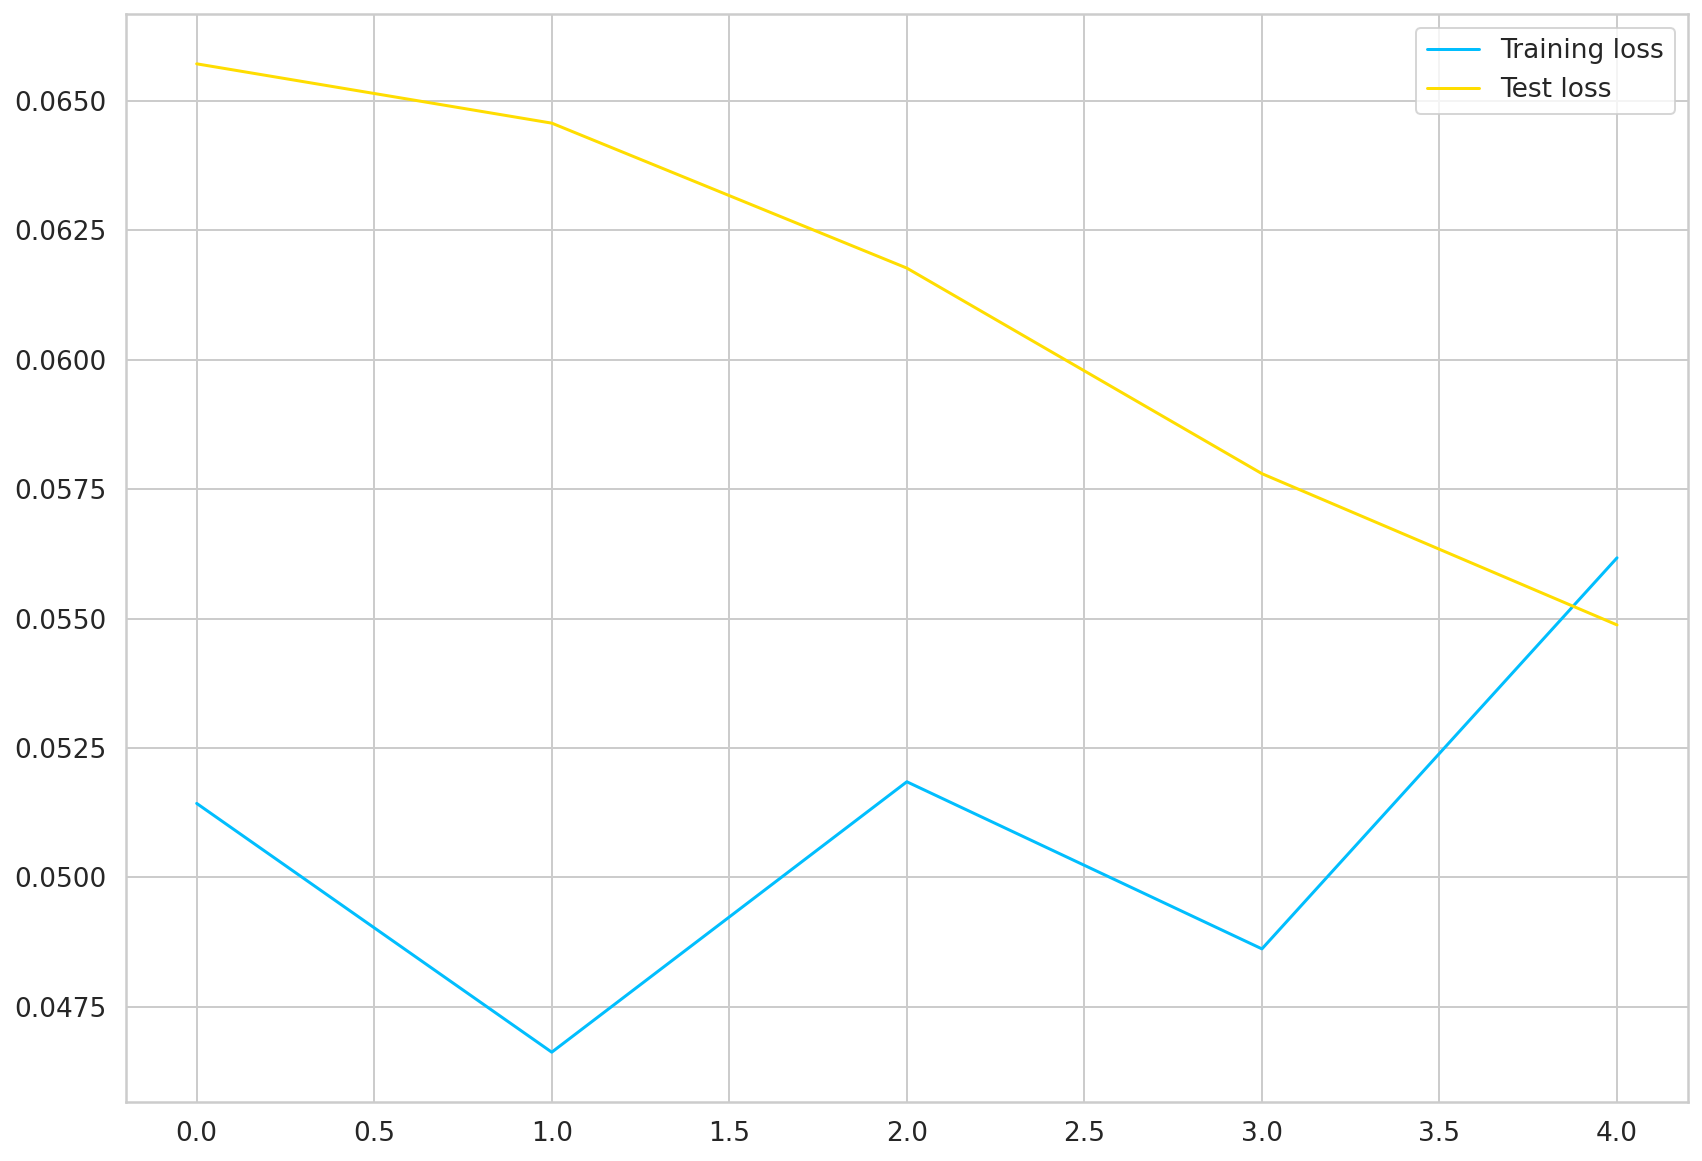

In [14]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();

In [16]:
Xtest, ytest, jim = get_test_batch(0)

with torch.no_grad():
    test_seq = Xtest[:1] # input first sequence from trajectory/batch
    preds = [] # create a list to store predictions.
    for i in range(len(Xtest)): # for each sequence i in the trajectory,
        y_test_pred = model(test_seq).to(device) # send sequence to model,
        pred = torch.flatten(y_test_pred).item() # reshape the model output,
        preds.append(pred) # and append to the list of predictions - preds.
        new_seq = Xtest[i] # Change sequence to the next one in the list.
        test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1) # change sequence to a torch Tensor
   

(72000, 5)
750


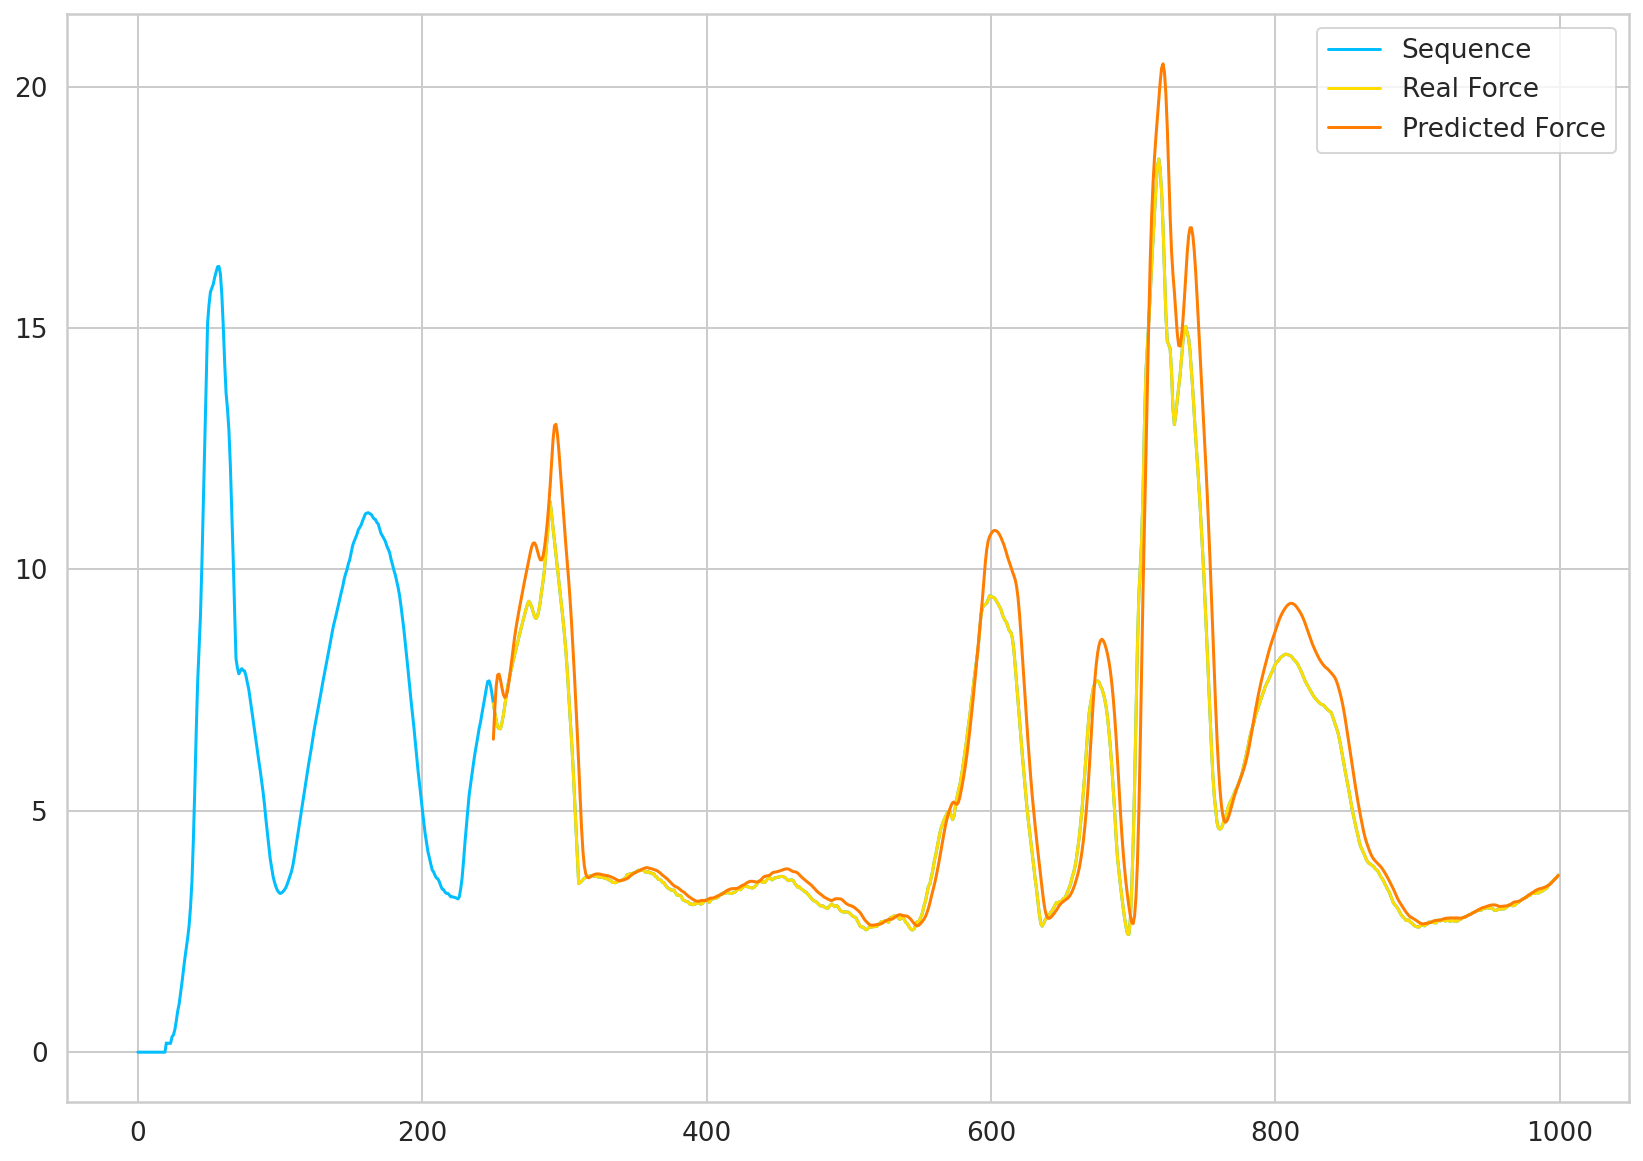

In [17]:
preds = np.asarray(preds)
preds = np.reshape(preds, (-1,1))

ytest2 = ytest.cpu()
ytest2 = np.asarray(ytest2)
ytest2 = np.reshape(ytest2, (-1,1))

predicted_cases = preds
true_cases = ytest2


print(main_seq.shape)
seq = pd.DataFrame(jim)
seq = seq.reset_index(drop=True)
#main_seq_reset = main_seq.reset_index(drop=True)

plt.plot(seq,label='Sequence')

print(len(predicted_cases))
plt.plot(seq.index[len(seq[:250]):1000], true_cases[:,-1], label='Real Force')

plt.plot(seq.index[len(seq[:250]):1000], predicted_cases[:,-1], label='Predicted Force')


# plt.plot(main_seq_reset.iloc[:1000,-1],label='Sequence')

# print(len(predicted_cases))
# plt.plot(main_seq_reset.index[len(seq[:550]):1000], true_cases, label='Real Force')

# plt.plot(main_seq_reset.index[len(seq[:550]):1000], predicted_cases, label='Predicted Force')

# plt.plot(true_cases)
# plt.plot(predicted_cases)

plt.legend();

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(data)

all_data = scaler.transform(data)

all_data.shape

In [ ]:
X_all, y_all = train_create_sequences( seq_length)

X_all = torch.cuda.FloatTensor(X_all)
y_all = torch.cuda.FloatTensor(y_all)

model = CoronaVirusPredictor(
  n_features=7, 
  n_hidden=512, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, _ = train_model(model, X_all, y_all)

In [ ]:
DAYS_TO_PREDICT = 5

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
    
        y_test_pred = model(test_seq).to(device)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        print(pred)
        new_seq = test_seq.cpu().numpy().flatten()
        new_seq = np.append(new_seq, [pred])
        new_seq = new_seq[1:]
        test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1)
        

In [ ]:
predicted_cases = scaler.inverse_transform(preds).flatten()
print(predicted_cases.shape)
                                           
# print(np.shape(preds))
# preds = np.asarray(preds)
# preds = preds.reshape([5,7])
# print(np.shape(preds))

# predicted_cases = scaler.inverse_transform(preds)                                           

In [ ]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

